In [1]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from shapely import geometry
sns.set_theme(style="darkgrid")

---
title: "Temporal analysis of domain shift"
subtitle : "(Tanzania Vs. Ivory Coast)"
author: "Martín Domínguez Durán"
date: today
format: 
    revealjs:
        theme: serif
        toc: true
        toc-depth: 2
        slide-number: true
        logo: ../imgs/WUR_Logo.png
        footer: Martín Domínguez Durán
        transition: fade
        smaller: true
        background-image : "../imgs/BG_Presentations.png"
---

In [2]:
ee.Initialize()

In [3]:
aoi_T = geemap.shp_to_ee('../Data/Vector/Cashew_Tanzania.shp')

In [4]:
# Code to divide ivory coast vector data in 6 so it can be handle by google earth engine
Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')
minX, minY, maxX, maxY = Ivy_qn.total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = (maxX - minX)/2.5
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2041')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_15420\2777370558.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')


## Precipitation

In [5]:
Precip = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(aoi_T).filter(ee.Filter.date('2013-07-31', '2023-07-31'))

data_prec = Precip.getRegion(aoi_T, scale = 5000).getInfo()

precip_df_T = pd.DataFrame(columns= data_prec[0], data = data_prec[1:])

In [6]:
# Add month to easily aggregate data monthly
precip_df_T['month'] = precip_df_T.apply(lambda df: pd.to_datetime(df['id'], format='%Y%m%d').month, axis=1)

In [7]:
Big_gdf = pd.DataFrame([])

for i in range(len(fishnet)):
    gdf = gpd.clip(Ivy_qn, fishnet.iloc[i].geometry)

    aoi_Iv = geemap.geopandas_to_ee(gdf)

    Precip = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(aoi_Iv).filter(ee.Filter.date('2013-07-31', '2023-07-31'))

    data_prec = Precip.getRegion(aoi_Iv, scale = 5000).getInfo()

    precip_df = pd.DataFrame(columns= data_prec[0], data = data_prec[1:])

    precip_df['month'] = precip_df.apply(lambda df: pd.to_datetime(df['id'], format='%Y%m%d').month, axis=1)        

    Big_gdf = Big_gdf.append(precip_df)

C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\563612684.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\563612684.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\563612684.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\563612684.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_1667

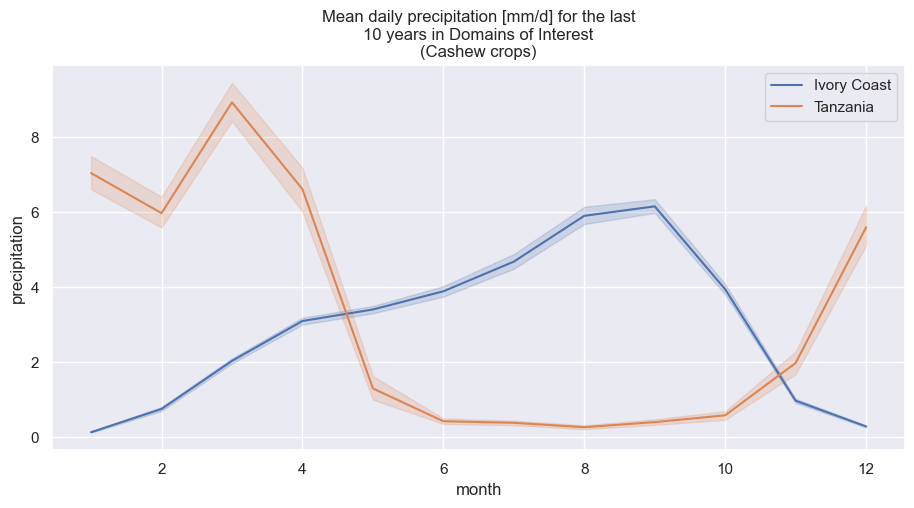

In [8]:
fig, ax = plt.subplots(1,1, figsize = (11,5))

sns.lineplot(data = Big_gdf,
             x = 'month',
             y = 'precipitation',
             errorbar=('ci', 95),
             ax = ax, 
             label = 'Ivory Coast')
sns.lineplot(data = precip_df_T,
             x = 'month', 
             y = 'precipitation',
             errorbar=('ci', 95),
             ax = ax,
             label = 'Tanzania')

ti = ax.set_title('Mean daily precipitation [mm/d] for the last\n10 years in Domains of Interest\n(Cashew crops)')

## Temperature

In [9]:
Temp = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filter(ee.Filter.date('2013-07-31', '2023-07-31')).select('temperature_2m')

In [10]:
data_temp = Temp.getRegion(aoi_T, scale = 5000).getInfo()
temp_df_T = pd.DataFrame(columns= data_temp[0], data = data_temp[1:])

In [11]:
temp_df_T['month'] = temp_df_T.apply(lambda df: pd.to_datetime(df['id'], format='%Y%m%d').month, axis=1)
temp_df_T['temperature_2m'] = temp_df_T['temperature_2m']-273.15

In [12]:
Big_gdf = pd.DataFrame([])

for i in range(len(fishnet)):
    gdf = gpd.clip(Ivy_qn, fishnet.iloc[i].geometry)

    aoi_Iv = geemap.geopandas_to_ee(gdf)

    data_prec = Temp.getRegion(aoi_Iv, scale = 5000).getInfo()

    precip_df = pd.DataFrame(columns= data_prec[0], data = data_prec[1:])

    precip_df['month'] = precip_df.apply(lambda df: pd.to_datetime(df['id'], format='%Y%m%d').month, axis=1)

    Big_gdf = Big_gdf.append(precip_df)

Big_gdf['temperature_2m'] = Big_gdf['temperature_2m']-273.15

C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2297593615.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2297593615.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2297593615.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2297593615.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_

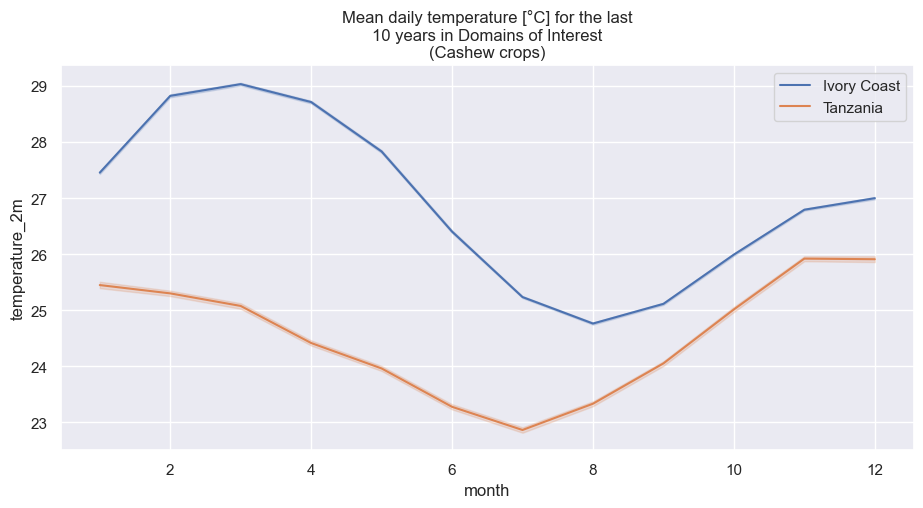

In [13]:
fig, ax = plt.subplots(1,1, figsize = (11,5))

sns.lineplot(data = Big_gdf,
             x = 'month',
             y = 'temperature_2m',
             errorbar=('ci', 95),
             ax = ax, 
             label = 'Ivory Coast')
sns.lineplot(data = temp_df_T,
             x = 'month', 
             y = 'temperature_2m',
             errorbar=('ci', 95),
             ax = ax,
             label = 'Tanzania')

ti = ax.set_title('Mean daily temperature [°C] for the last\n10 years in Domains of Interest\n(Cashew crops)')

## Vegetation indices

In [14]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filter(ee.Filter.date('2019-07-31', '2023-07-31')).select('B4','B8', 'MSK_CLDPRB')

S2 = S2.map(lambda im : im.mask(im.select('MSK_CLDPRB').eq(0)).normalizedDifference(['B8','B4']))

In [15]:
S2_T = S2.filterBounds(aoi_T)

In [16]:
data_ndvi = S2_T.getRegion(aoi_T, scale = 500).getInfo()

ndvi_df_T = pd.DataFrame(columns= data_ndvi[0], data = data_ndvi[1:])

In [17]:
ndvi_df_T['month'] = ndvi_df_T.apply(lambda df: pd.to_datetime(df['id'][:8], format='%Y%m%d').month, axis=1)

In [18]:
# Code to divide ivory coast vector data in 6 so it can be handle by google earth engine
Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')
minX, minY, maxX, maxY = Ivy_qn.total_bounds

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = (maxX - minX)/5
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2041')

C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\1888330186.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  Ivy_qn = gpd.read_file('../Data/Vector/Cashew_Ivorycoast.shp').explode().to_crs('EPSG:2041')


In [24]:
Big_gdf = pd.DataFrame([])

for i in range(len(fishnet)):
    gdf = gpd.clip(Ivy_qn, fishnet.iloc[i].geometry)

    if len(gdf) > 0:

        aoi_Iv = geemap.geopandas_to_ee(gdf)
    
        S2_Iv = S2.filterBounds(aoi_Iv).map(lambda im: im.clip(aoi_Iv))
    
        data_prec = S2_Iv.getRegion(aoi_Iv, scale = 500).getInfo()
    
        precip_df = pd.DataFrame(columns= data_prec[0], data = data_prec[1:])
    
        # precip_df = precip_df.dropna()
        if len(precip_df) > 0:        
            precip_df['date'] = precip_df.apply(lambda df: pd.to_datetime(df['id'][:8], format='%Y%m%d', errors = 'ignore'), axis=1)
    
            precip_df['month'] = precip_df.apply(lambda df: df['date'].month if type(df['date']) != str else np.nan, axis=1)

            Big_gdf = Big_gdf.append(precip_df)


C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2928982952.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2928982952.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2928982952.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_16672\2928982952.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Big_gdf = Big_gdf.append(precip_df)
C:\Users\mdomi\AppData\Local\Temp\ipykernel_

In [25]:
Big_gdf = Big_gdf[['nd','month']].dropna()

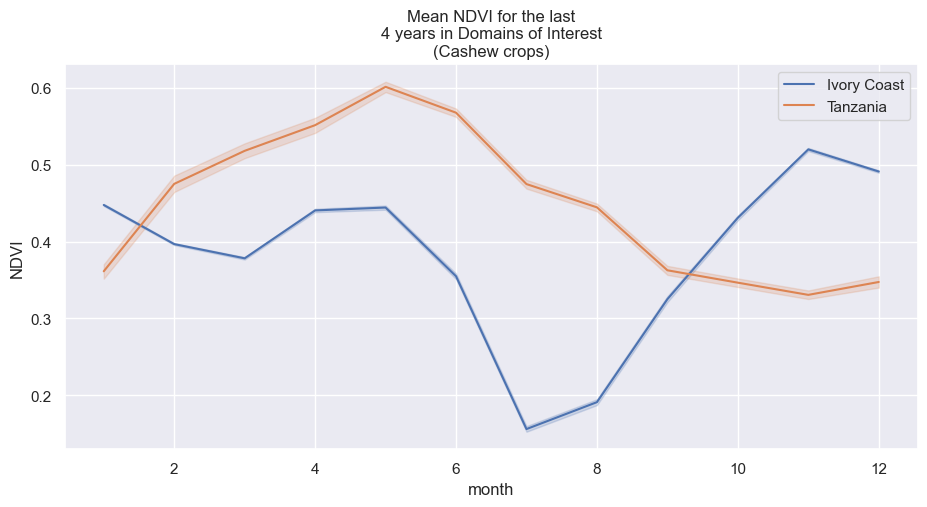

In [26]:
fig, ax = plt.subplots(1,1, figsize = (11,5))

sns.lineplot(data = Big_gdf,
             x = 'month',
             y = 'nd',
             errorbar=('ci', 95),
             ax = ax, 
             label = 'Ivory Coast')
sns.lineplot(data = ndvi_df_T,
             x = 'month', 
             y = 'nd',
             errorbar=('ci', 95),
             ax = ax,
             label = 'Tanzania')

ax.set_ylabel('NDVI')
ti = ax.set_title('Mean NDVI for the last\n4 years in Domains of Interest\n(Cashew crops)')

In [27]:
Big_gdf

,nd,month
52,0.672164,10
61,0.725065,11
76,0.741814,12
91,0.672636,12
94,0.656077,1
...,...,...
6955,0.378174,4
6959,0.360910,4
6967,0.624570,5
6975,0.616069,6
